In [1]:
# 필요한 기본 패키지 준비

# 데이터 처리 필요 패키지
import numpy as np
import pandas as pd
import datetime as dt
import math

# 시각화 필요 패키지
%matplotlib inline
from plotnine import *
import folium
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
import seaborn as sns


# Machine Learning 분석 환경 준비

# 전처리, 스케일링
from sklearn.preprocessing import StandardScaler

# 선형회귀분석
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy import stats

# OLS회귀분석
import statsmodels.api as sm

# GAM 일반화가법모형
# LinearGAM, LogisticGAM, PoissonGAM, GammaGAM, InvGuss
from pygam import LinearGAM, LogisticGAM, PoissonGAM, GammaGAM

# Boosting

#데이터셋 분리
from sklearn.model_selection import train_test_split



# 한글 처리
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# jupyter notebook에서 warning 무시하기
import warnings
warnings.filterwarnings("ignore")

In [2]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1))
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df

In [3]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

In [4]:
# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

# 컬럼 이름을 변경하여 Series로 돌려주는 함수
sns_all.columns = changeColNames(sns_all,'.','_')
# ols formula입력시 오류 발생 방지를위해 컬럼명 문자열 내, 마침표(.)가 전부 underscore(_)로 변경
# sns_all.columns

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']
lv_grouped = lv_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()
# lv_grouped.tail(2)

# 마스크팩

## 일단위 자료
#### 함수를 만들기전, 함수에 들어갈 코딩을 위한 사전 작업

In [8]:
# 서울특별시 단위로 df조정(구단위 데이터 합치기)
day_lv_grouped = lv_grouped.groupby(by=['date','category']).sum().reset_index()
# day_lv_grouped.tail(3)

# '마스크팩'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'day_gs_grouped_w_item'생성
item = '마스크팩'
day_lv_grouped_w_item = pd.merge(day_lv_grouped.loc[day_lv_grouped.category==item],w_seoul,on='date',how='left')
day_lv_grouped_w_sns_item = pd.merge(day_lv_grouped_w_item, sns_all,on='date',how='left')

# 날씨 - 'uv'제외. 향후 uv결측치 처리후 적용
ind_vars_w = ['temp','humid','wind','rain','snow','cloud','sun_time','lgt_time','SO2','CO','O3','NO2','PM10','PM25']
ind_vars_s = ['pm_total', 'health_total','br_total', 'hobby_total','date_total']

print('\n날씨 데이터와 %s 판매량의 상관관계'%item)
linReg(day_lv_grouped_w_sns_item,item,ind_vars_w)
ridgeReg(day_lv_grouped_w_sns_item,item,ind_vars_w)
lassoReg(day_lv_grouped_w_sns_item,item,ind_vars_w)
print('\n소셜 데이터와 %s 판매량의 상관관계'%item)
linReg(day_lv_grouped_w_sns_item,item,ind_vars_s)
ridgeReg(day_lv_grouped_w_sns_item,item,ind_vars_s)
lassoReg(day_lv_grouped_w_sns_item,item,ind_vars_s)


print('\n날씨&소셜 데이터와 %s 판매량의 상관관계'%item)
ind_vars = ['temp','humid','wind','rain','snow','cloud','sun_time','lgt_time','SO2','CO','O3','NO2','PM10','PM25'
             ,'pm_total', 'health_total','br_total', 'hobby_total','date_total']
linReg(day_lv_grouped_w_sns_item,item,ind_vars)
ridgeReg(day_lv_grouped_w_sns_item,item,ind_vars)
lassoReg(day_lv_grouped_w_sns_item,item,ind_vars)

Xy = day_lv_grouped_w_sns_item.loc[day_lv_grouped_w_sns_item['category']==item,ind_vars+['qty']]

ols_formula = "qty ~ "
w_formula = "temp + humid + wind + rain + snow + cloud + sun_time + lgt_time"
s_formula = "pm_total + health_total + br_total + hobby_total + date_total"
airPol_formula = "SO2 + CO + O3 + NO2 + PM10 + PM25"

# 모든 변수(uv제외)적용
model = sm.OLS.from_formula(ols_formula+" + ".join([w_formula,s_formula, airPol_formula]), data=Xy)

print(model.fit().summary())


날씨 데이터와 마스크팩 판매량의 상관관계
LinearRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.04
검증세트점수 : 0.02
RidgeRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.03
검증세트점수 : 0.02
LassoRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.04
검증세트점수 : 0.02
사용한 특성수 : 13

소셜 데이터와 마스크팩 판매량의 상관관계
LinearRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.01
검증세트점수 : -0.01
RidgeRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.01
검증세트점수 : -0.00
LassoRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.01
검증세트점수 : -0.01
사용한 특성수 : 5

날씨&소셜 데이터와 마스크팩 판매량의 상관관계
LinearRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.04
검증세트점수 : 0.02
RidgeRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.04
검증세트점수 : 0.02
LassoRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.04
검증세트점수 : 0.02
사용한 특성수 : 19
                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:       

## 주단위 자료 생성

#### 자료생성 파트

In [9]:
cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# '마스크팩'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'week_gs_grouped'생성
item = '마스크팩'
week_lv_grouped = lv_grouped.groupby(by=['date','category']).sum().reset_index()
# week_lv_grouped.tail(2)
week_lv_grouped_gu =week_lv_grouped.loc[week_lv_grouped.category==item]
# week_lv_grouped_gu.tail(3)

# '마스크팩'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'week_gs_grouped'생성
week_lv_grouped_item = week_lv_grouped.loc[week_lv_grouped.category==item].reset_index()
# 이제 'week_lv_grouped_item'에 한 날짜에 한 item(마스크팩)만 들어가있는 df가 됨.

week_lv_grouped_w_item = pd.merge(week_lv_grouped,w,on='date',how='left')
week_lv_grouped_w_item_sns = pd.merge(week_lv_grouped_w_item,sns_all,on='date',how='left')
# week_lv_grouped_w_item_sns.tail(2)


week_w = addDayWeek(w_seoul)
week_w = week_w.groupby('week').mean().reset_index()
week_w.drop(columns=['loc','day','year','month','weekday','nth_week'], inplace=True)
# week_w.tail(2)

# sns자료는 2019년 4월달 자료 까지 있다.
week_sns = addDayWeek(sns_all.loc[sns_all.date.between('2016-01-01','2018-12-31', inclusive=True)])
# week_sns = week_sns.groupby('week').sum().reset_index()
week_sns = week_sns.groupby('week').mean().reset_index()
# week_sns.tail(2)

check = addDayWeek(week_lv_grouped_item)
check.drop(columns='index',inplace=True)
# check = check[['week','category','qty']].groupby(by=['week','category']).sum().reset_index()
check = check[['week','category','qty']].groupby(by=['week','category']).mean().reset_index()
# check.tail()
check_merged = mergeForAnalysis(check, week_w, week_sns, item, on_what='week')
# check_merged.columns

#### 예측모델 파트

In [11]:
ind_vars = ['temp','humid','wind','rain','snow','cloud','sun_time','lgt_time','SO2','CO','O3','NO2','PM10','PM25'
             ,'pm_total', 'health_total','br_total', 'hobby_total','date_total']
ind_vars_w = ['temp','humid','wind','rain','snow','cloud','sun_time','SO2','CO','O3','NO2','PM10','PM25']
ind_vars_s = ['pm_total', 'health_total','br_total', 'hobby_total','date_total']

print('\n날씨 데이터와 %s 판매량의 상관관계'%item)
linReg(check_merged,item,ind_vars_w)
ridgeReg(check_merged,item,ind_vars_w)
lassoReg(check_merged,item,ind_vars_w)
print('\n소셜 데이터와 %s 판매량의 상관관계'%item)
linReg(check_merged,item,ind_vars_s)
ridgeReg(check_merged,item,ind_vars_s)
lassoReg(check_merged,item,ind_vars_s)

print('\n날씨&소셜 데이터와 %s 판매량의 상관관계'%item)
linReg(check_merged,item,ind_vars)
ridgeReg(check_merged,item,ind_vars)
lassoReg(check_merged,item,ind_vars)
print('')
# ols모델
Xy = check_merged.loc[check_merged['category']==item, ind_vars+['qty']]

ols_formula = "qty ~ "
w_formula = "temp + humid + wind + rain + snow + cloud + sun_time + lgt_time"
s_formula = "pm_total + health_total + br_total + hobby_total + date_total"
airPol_formula = "SO2 + CO + O3 + NO2 + PM10 + PM25"

# 모든 변수(uv제외)적용
model = sm.OLS.from_formula(ols_formula+" + ".join([w_formula,s_formula, airPol_formula]), data=Xy)

# 임의로 상관있다 생각되는 변수만
custom_formula = "qty ~ temp + sun_time + rain + health_total"
# model = sm.OLS.from_formula(custom_formula, data=Xy)

print(model.fit().summary())


날씨 데이터와 마스크팩 판매량의 상관관계
LinearRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.11
검증세트점수 : -0.01
RidgeRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.09
검증세트점수 : 0.04
LassoRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.11
검증세트점수 : -0.00
사용한 특성수 : 13

소셜 데이터와 마스크팩 판매량의 상관관계
LinearRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.03
검증세트점수 : -0.04
RidgeRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.03
검증세트점수 : -0.04
LassoRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.03
검증세트점수 : -0.04
사용한 특성수 : 5

날씨&소셜 데이터와 마스크팩 판매량의 상관관계
LinearRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.15
검증세트점수 : -0.06
RidgeRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.14
검증세트점수 : 0.01
LassoRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.15
검증세트점수 : -0.06
사용한 특성수 : 19

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:  

# uv데이터를 사용해서 예측진행
## uv 데이터 사용전 데이터 처리

In [12]:
cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# '마스크팩'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'week_gs_grouped'생성
item = '마스크팩'
week_lv_grouped = lv_grouped.groupby(by=['date','category']).sum().reset_index()
# week_lv_grouped.tail(2)
week_lv_grouped_gu =week_lv_grouped.loc[week_lv_grouped.category==item]
# week_lv_grouped_gu.tail(3)

# '마스크팩'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'week_gs_grouped'생성
week_lv_grouped_item = week_lv_grouped.loc[week_lv_grouped.category==item].reset_index()
# 이제 'week_lv_grouped_item'에 한 날짜에 한 item(마스크팩)만 들어가있는 df가 됨.

week_lv_grouped_w_item = pd.merge(week_lv_grouped,w,on='date',how='left')
week_lv_grouped_w_item_sns = pd.merge(week_lv_grouped_w_item,sns_all,on='date',how='left')
# week_lv_grouped_w_item_sns.tail(2)


week_w = addDayWeek(w_seoul)
week_w = week_w.groupby('week').mean().reset_index()
week_w.drop(columns=['loc','day','year','month','weekday','nth_week'], inplace=True)
# week_w.tail(2)

# sns자료는 2019년 4월달 자료 까지 있다.
week_sns = addDayWeek(sns_all.loc[sns_all.date.between('2016-01-01','2018-12-31', inclusive=True)])
# week_sns = week_sns.groupby('week').sum().reset_index()
week_sns = week_sns.groupby('week').mean().reset_index()
# week_sns.tail(2)

check = addDayWeek(week_lv_grouped_item)
check.drop(columns='index',inplace=True)
# check = check[['week','category','qty']].groupby(by=['week','category']).sum().reset_index()
check = check[['week','category','qty']].groupby(by=['week','category']).mean().reset_index()
# check.tail()
check_merged = mergeForAnalysis(check, week_w, week_sns, item, on_what='week')
# check_merged.columns

In [13]:
# uv데이터는 결측치가 많다.
print('UV 데이터 포함(결측치가 있는 주는 제거)')
check_merged = check_merged.loc[check_merged.uv.notnull()]

ind_vars = ['temp','humid','wind','rain','snow','cloud','sun_time','lgt_time','uv','SO2','CO','O3','NO2','PM10','PM25'
             ,'pm_total', 'health_total','br_total', 'hobby_total','date_total']
ind_vars_w = ['temp','humid','wind','rain','snow','cloud','sun_time','SO2','CO','O3','NO2','PM10','PM25']
ind_vars_s = ['pm_total', 'health_total','br_total', 'hobby_total','date_total']

print('\n날씨 데이터와 %s 판매량의 상관관계'%item)
linReg(check_merged,item,ind_vars_w)
ridgeReg(check_merged,item,ind_vars_w)
lassoReg(check_merged,item,ind_vars_w)
print('\n소셜 데이터와 %s 판매량의 상관관계'%item)
linReg(check_merged,item,ind_vars_s)
ridgeReg(check_merged,item,ind_vars_s)
lassoReg(check_merged,item,ind_vars_s)

print('\n날씨&소셜 데이터와 %s 판매량의 상관관계'%item)
linReg(check_merged,item,ind_vars)
ridgeReg(check_merged,item,ind_vars)
lassoReg(check_merged,item,ind_vars)
print('')
# ols모델
Xy = check_merged.loc[check_merged['category']==item, ind_vars+['qty']]

ols_formula = "qty ~ "
w_formula = "temp + humid + wind + rain + snow + cloud + sun_time + lgt_time + uv"
s_formula = "pm_total + health_total + br_total + hobby_total + date_total"
airPol_formula = "SO2 + CO + O3 + NO2 + PM10 + PM25"

# 모든 변수(uv제외)적용
# model = sm.OLS.from_formula(ols_formula+" + ".join([w_formula,s_formula, airPol_formula]), data=Xy)

# 임의로 상관있다 생각되는 변수만
custom_formula = "qty ~ sun_time + lgt_time + health_total"
model = sm.OLS.from_formula(custom_formula, data=Xy)

print(model.fit().summary())

UV 데이터 포함(결측치가 있는 주는 제거)

날씨 데이터와 마스크팩 판매량의 상관관계
LinearRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.15
검증세트점수 : -0.05
RidgeRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.13
검증세트점수 : 0.03
LassoRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.15
검증세트점수 : -0.03
사용한 특성수 : 13

소셜 데이터와 마스크팩 판매량의 상관관계
LinearRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.18
검증세트점수 : -0.51
RidgeRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.17
검증세트점수 : -0.39
LassoRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.18
검증세트점수 : -0.51
사용한 특성수 : 5

날씨&소셜 데이터와 마스크팩 판매량의 상관관계
LinearRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.37
검증세트점수 : -1.35
RidgeRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.31
검증세트점수 : -0.37
LassoRegression을 이용한 마스크팩의 회귀분석 결과 :
훈련세트점수 : 0.37
검증세트점수 : -1.30
사용한 특성수 : 20

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Leas

### 임의로 Xy['qty']>15000인 값만 제거후

<function matplotlib.pyplot.show(*args, **kw)>

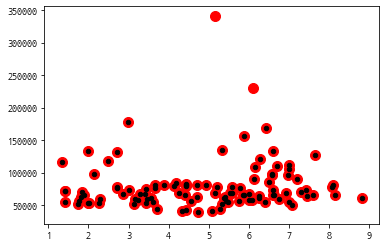

In [16]:
plt.scatter(Xy['uv'],Xy['qty'], c='r',s=100)

Xy_no_outlier = Xy.copy()
df_working = Xy.loc[Xy.qty<200_000]

plt.scatter(df_working['uv'],df_working['qty'], c='k',s=20)
plt.show

In [17]:
model = sm.OLS.from_formula(
    "qty ~ I(uv**2)"
    , data=df_working)


# model = sm.OLS.from_formula("qty ~ temp + uv + pm_total + health_total ", data=df_working)
ols_model = model.fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.231
Date:                Fri, 12 Jul 2019   Prob (F-statistic):              0.270
Time:                        11:38:30   Log-Likelihood:                -1195.5
No. Observations:                 103   AIC:                             2395.
Df Residuals:                     101   BIC:                             2400.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.175e+04   4747.266     15.114      0.0

### MAD기법 적용

<function matplotlib.pyplot.show(*args, **kw)>

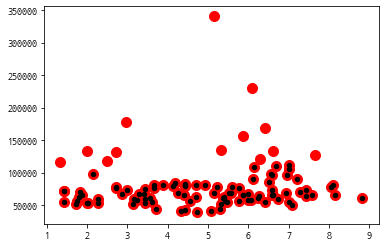

In [18]:
plt.scatter(Xy['uv'],Xy['qty'], c='r',s=100)

df_working = Xy.copy()
df_working['outlier'] = mad_based_outlier(df_working['qty'],thresh=2.5)
df_working = Xy_no_outlier.loc[df_working.outlier==False]
#Xy_no_outlier = Xy.loc[df_working.qty<200_000]

plt.scatter(df_working['uv'],df_working['qty'], c='k',s=20)
plt.show

In [19]:
model = sm.OLS.from_formula(
    "qty ~ I(uv**2)"
    , data=df_working)

# model = sm.OLS.from_formula("qty ~ temp + uv + pm_total + health_total ", data=df_working)
ols_model = model.fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     6.487
Date:                Fri, 12 Jul 2019   Prob (F-statistic):             0.0126
Time:                        11:39:39   Log-Likelihood:                -1015.1
No. Observations:                  92   AIC:                             2034.
Df Residuals:                      90   BIC:                             2039.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.262e+04   2864.171     21.863      0.0

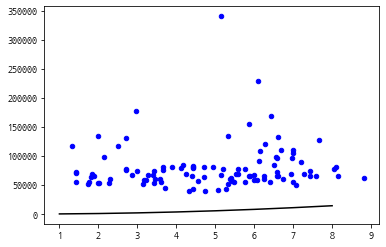

In [21]:
# 이상치 제거한 자료로 산출한 모델을 이상치제거 하지않은 원본 데이터와 비교
intercept = 223.6342    
c1 = 223.6342   

plt.scatter(Xy['uv'],Xy['qty'], c='b',s=20)

uv_list = pd.Series(list(range(int(Xy.uv.min()),int(Xy.uv.max())+1)))
plt.plot(uv_list, intercept + c1*(uv_list ** 2), c='k')

plt.show()

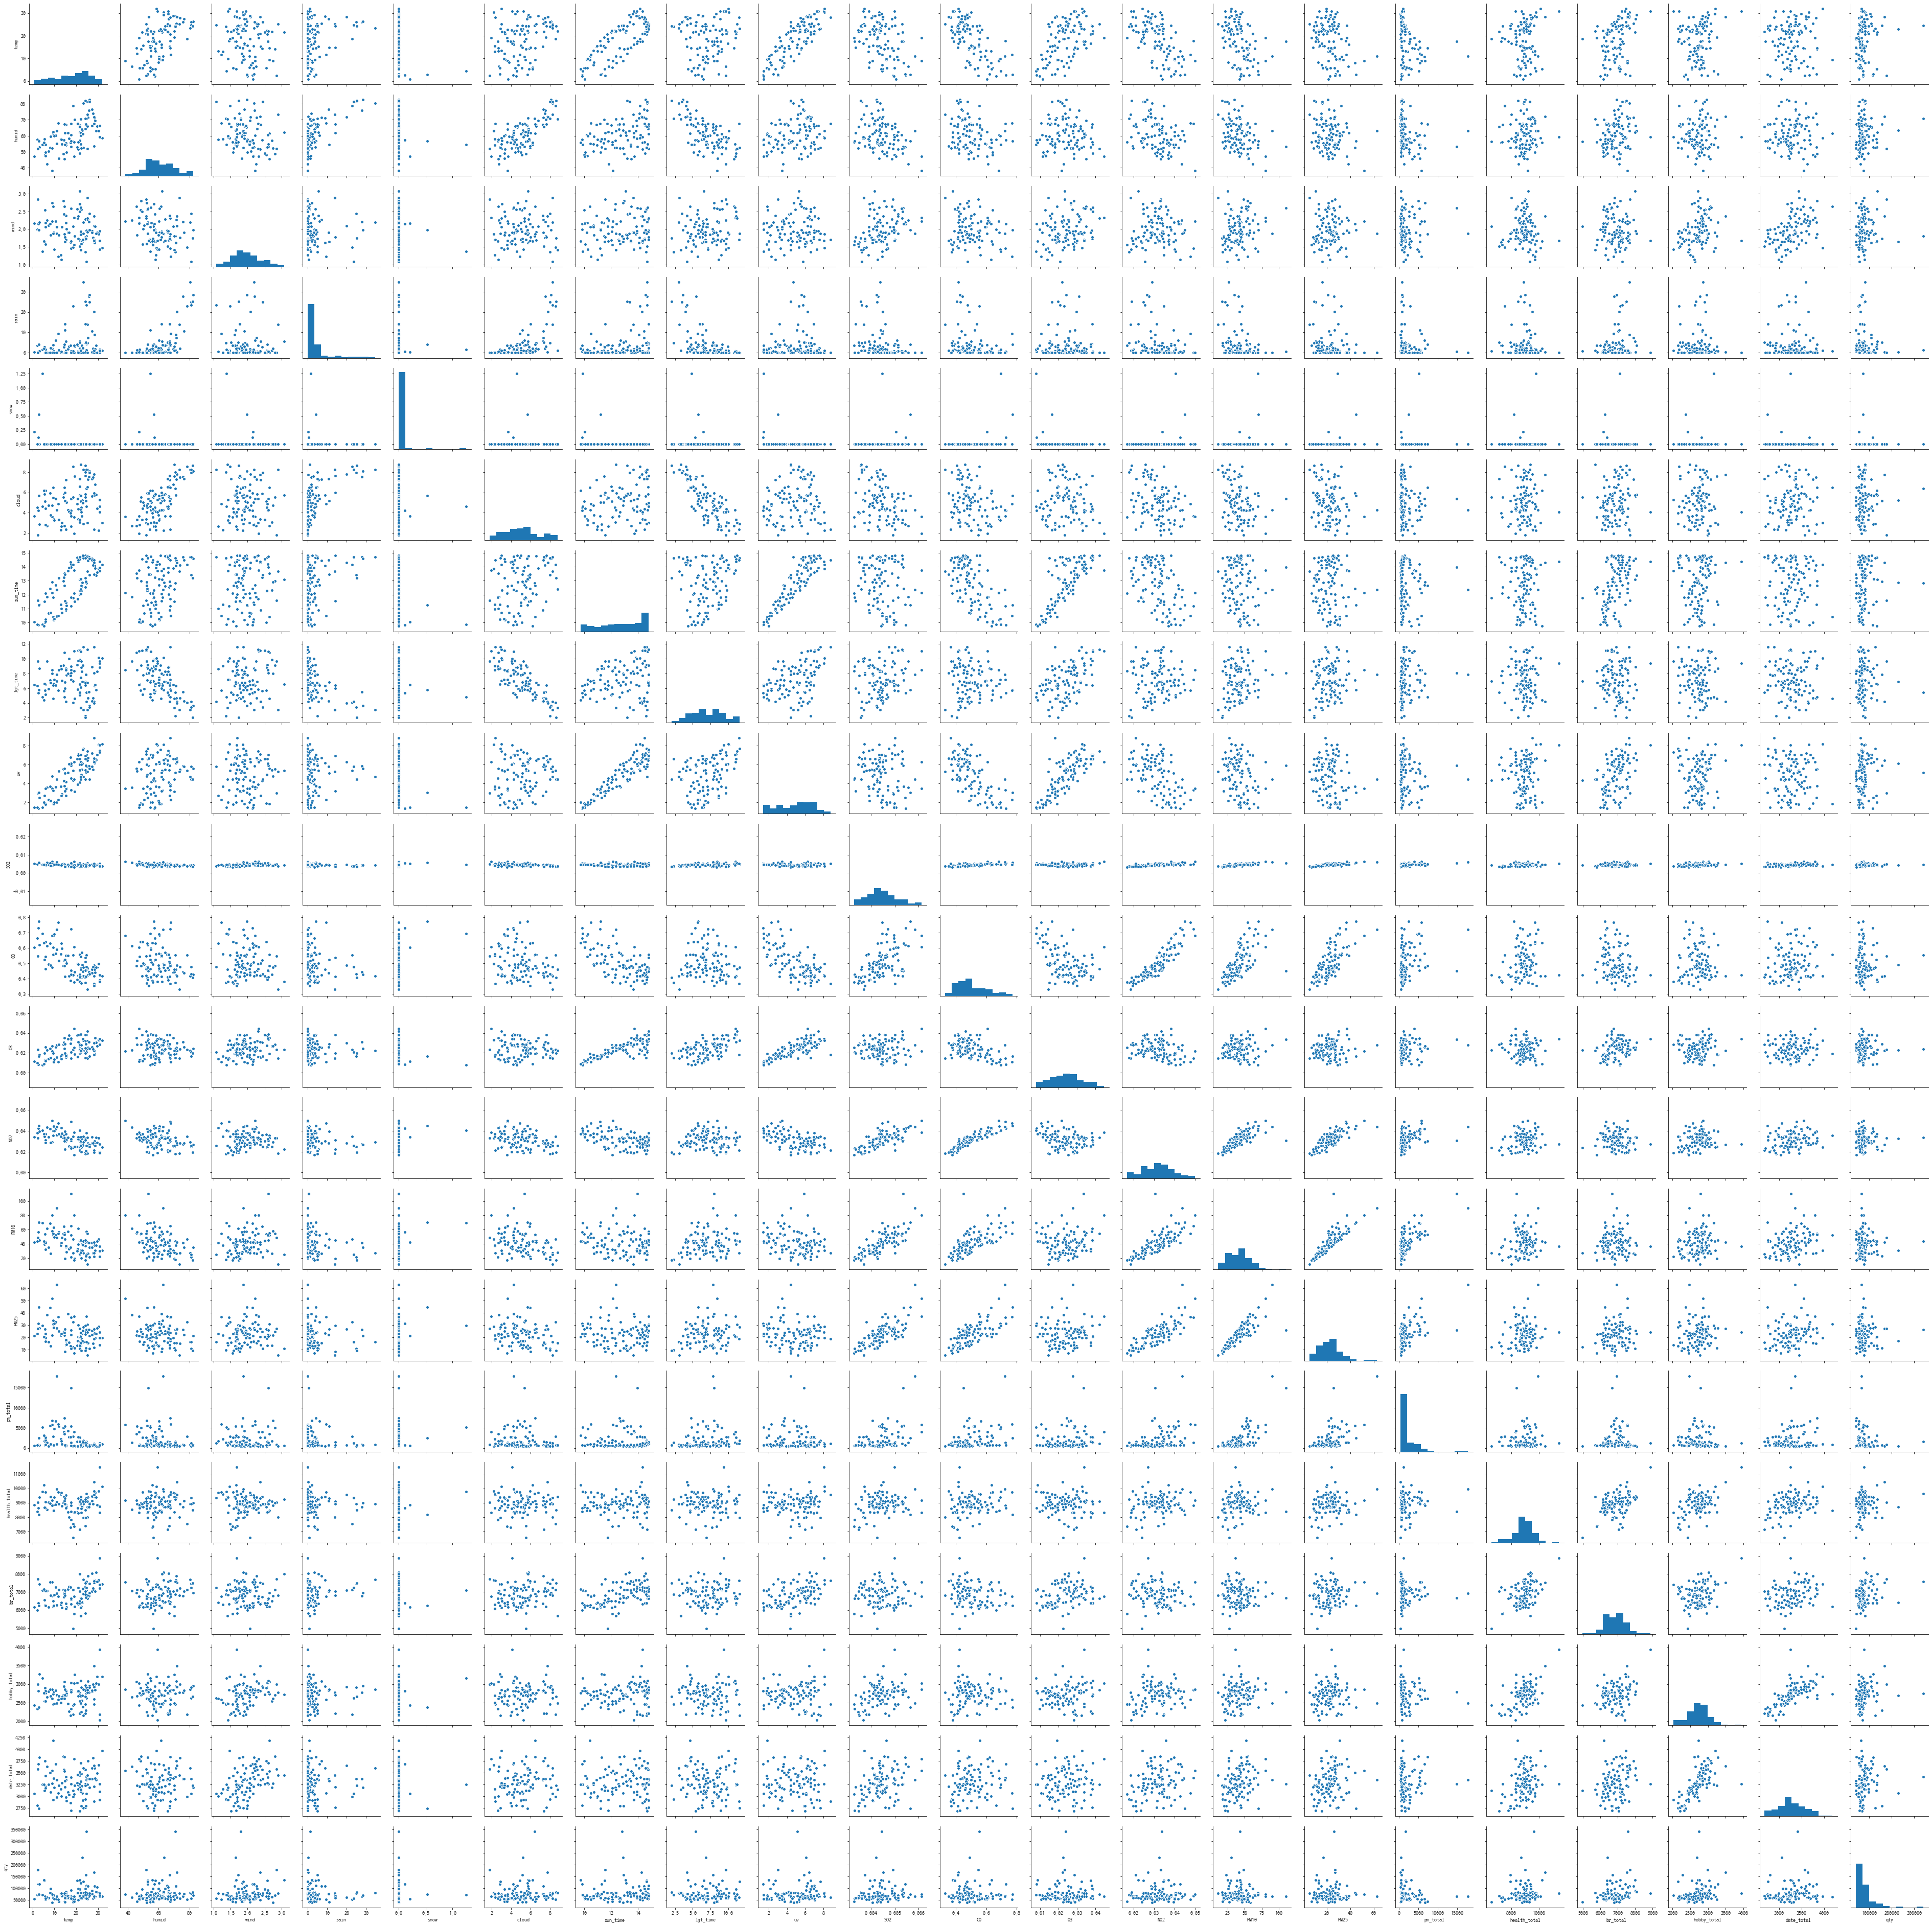

In [22]:
sns.pairplot(Xy)

In [23]:
Xy.corr()

,temp,humid,wind,rain,snow,cloud,sun_time,lgt_time,uv,SO2,...,O3,NO2,PM10,PM25,pm_total,health_total,br_total,hobby_total,date_total,qty
temp,1.000000,0.555801,-0.122384,0.259639,-0.268564,0.317722,0.770667,0.057164,0.846319,-0.386099,...,0.526472,-0.584777,-0.424912,-0.312087,-0.293732,0.082017,0.346705,0.119748,0.015211,0.106122
humid,0.555801,1.000000,-0.258589,0.681033,-0.101632,0.720258,0.372247,-0.621862,0.239996,-0.383333,...,-0.070197,-0.329353,-0.391962,-0.198915,-0.220946,0.045697,0.223341,0.023145,-0.001758,0.121696
wind,-0.122384,-0.258589,1.000000,-0.055555,-0.123086,-0.040966,0.074319,0.138921,0.000051,0.348275,...,0.224702,-0.037086,0.187814,0.004438,0.071182,-0.077077,-0.015950,0.304329,0.463145,0.084750
rain,0.259639,0.681033,-0.055555,1.000000,-0.044702,0.627983,0.315140,-0.553591,0.069740,-0.268268,...,-0.035640,-0.241779,-0.271365,-0.166111,-0.116308,-0.070267,0.206025,-0.021169,-0.021642,-0.094103
snow,-0.268564,-0.101632,-0.123086,-0.044702,1.000000,-0.029278,-0.245101,-0.123748,-0.243474,0.105400,...,-0.251150,0.195267,0.222065,0.156065,0.099263,0.068204,-0.026901,0.074527,-0.081437,-0.025471
cloud,0.317722,0.720258,-0.040966,0.627983,-0.029278,1.000000,0.284147,-0.809999,0.073574,-0.338481,...,-0.072370,-0.320724,-0.311653,-0.224312,-0.117486,-0.023704,0.125948,0.012654,0.058655,0.051163
sun_time,0.770667,0.372247,0.074319,0.315140,-0.245101,0.284147,1.000000,0.177405,0.916467,-0.133175,...,0.779528,-0.458340,-0.141676,-0.084354,0.004695,0.001253,0.483016,0.067275,0.033966,0.062763
lgt_time,0.057164,-0.621862,0.138921,-0.553591,-0.123748,-0.809999,0.177405,1.000000,0.387798,0.241925,...,0.504022,0.045867,0.208620,0.148345,0.113358,-0.024204,0.028989,-0.053565,-0.080905,-0.029341
uv,0.846319,0.239996,0.000051,0.069740,-0.243474,0.073574,0.916467,0.387798,1.000000,-0.182825,...,0.776276,-0.501749,-0.196508,-0.135200,-0.071544,0.053350,0.443923,0.039215,-0.033470,0.098213
SO2,-0.386099,-0.383333,0.348275,-0.268268,0.105400,-0.338481,-0.133175,0.241925,-0.182825,1.000000,...,0.061671,0.713240,0.777335,0.749431,0.403793,0.214065,0.027055,0.296107,0.335244,0.047444
